# Build CNN

# 1 - Initialization

1. Convolution
2. Pooling
3. Full Connection

![](https://wx1.sinaimg.cn/mw1024/701c57e5gy1gdr7xpxomsj20xk0bejtc.jpg)


In [45]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%reload_ext autoreload
%autoreload 2

np.random.seed(1)

In [67]:
class Conv2d ():
    def __init__ (self, A, n_Cnext, hyperparameters):
        # (样本数, 长度, 宽度, RGB数量(通道数量))
        self.A = A
        (m, n_H, n_W, n_C) = A.shape
        self.m = m
        self.n_H = n_H
        self.n_W = n_W
        self.n_C = n_C
        # 输出通道数量(depth: 立方体的深度)
        self.n_Cnext = n_Cnext
        
        # hyperparameters
        self.hyperparams = hyperparameters
        f = hyperparameters['filter']
        p = hyperparameters['padding']
        s = hyperparameters['stride']
        self.f, self.p, self.s = f, p, s
        
        # W, b
        self.W = np.random.rand(f, f, n_C, n_Cnext)
        self.b = np.random.rand(1, 1, 1, n_Cnext)
        
        # derivatives
        self.dJ_dW = np.zeros(shape = self.W.shape)
        self.dJ_db = np.zeros(shape = self.b.shape)
        
        # if add padding
        pad_width = ((0, 0), (p, p), (p, p), (0, 0))
        self.A_pad = np.pad(A, pad_width, 'constant', constant_values = 0)
        
        # Z_OUTPUT
        self.n_H_next = int((n_H - f + 2 * p) / s) + 1
        self.n_W_next = int((n_W - f + 2 * p) / s) + 1
        self.Z = np.ones(shape = (m, self.n_H_next, self.n_W_next, n_Cnext))
        
        print('Weights/Filters:', self.W.shape)
        print('bias:', self.b.shape)
        print('derivatives W, b:', self.dJ_dW.shape, self.dJ_db.shape)
        print('A_pad:', self.A_pad.shape)
        print('Z_OUTPUT: ', self.Z.shape)

    def _Conv (self):
        # 1. m个样本, 取一张照片
        for _m in range(self.m):
            A_m = self.A_pad[_m] # n_H, n_W, n_C
            # 2. 一张照片的高
            for _h in range(self.n_H_next):
                # 3. 一张照片的宽
                for _w in range(self.n_W_next):
                    # 4. 第_c个filter/weights (filter用来提取该图像的信息, filter有横的竖的, 各个方向对图像进行边缘提取)
                    for _c in range(self.n_Cnext):
                        # 5. 图像根据filter尺寸, 分块儿
                        # 按照FC逻辑来说, 选取要和weights进行匹配的neurons
                        s, f = self.s, self.f # stride, filter
                        w_start = _w * s
                        w_end = _w * s + f
                        h_start = _h * s
                        h_end = _h * s + f
                        
                        # 图像块儿: 图像高宽固定, 深度保持RGB
                        A_m_slice = A_m[h_start: h_end, w_start: w_end, :]
                        
                        # 6. 图像块儿 和 weights 对应位置相乘 + b
                        Z_slice = A_m_slice * self.W[:, :, :, _c] + self.b[:, :, :, _c]
                        
                        # 7. 提取边界是个叠加的值
                        Z_slice_sum = np.sum(Z_slice)
                        
                        # 8. 放到新的输出里面
                        self.Z[_m, _h, _w, _c] = Z_slice_sum
        
        cache = (A, self.A, self.W, self.b, self.hyperparams)
        return self.Z, cache
    
    def _Relu (self, Z):
        self.Z_relu = np.maximum(0, Z)
        return self.Z_relu
          
     
    def _Max_Pooling (self, A, f = 2, s = 2):
        self.pool_s = s
        self.pool_f = f
        
        (m, n_H, n_W, n_C) = A.shape
        n_W_next = int((n_W - f) / 2 )  + 1
        n_H_next = int((n_H - f) / 2 )  + 1
        
        self.A_maxpool = np.zeros(shape = (m, n_H_next, n_W_next, n_C))
        
        # 1. 处理一张图像
        for _m in range(m):
            A_m = A[_m]
            # 2. 高
            for _h in range(n_H_next):
                # 3. 宽
                for _w in range(n_W_next):
                    # 4. 通道 channel
                    for _c in range(n_C):
                        w_start = _w * s
                        w_end = _w * s + f
                        h_start = _h * s
                        h_end = _h * s + f
                        
                        # 某个图像块儿
                        A_m_slice = A_m[h_start: h_end, w_start: w_end, _c]
                        
                        # 放到新的输出里
                        self.A_maxpool[_m, _h, _w, _c] = np.max(A_m_slice)
                        
        return self.A_maxpool
            

(1, 100, 100, 3)


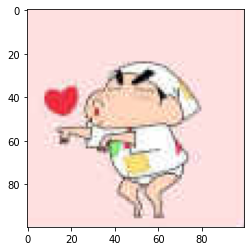

In [68]:
# 参数
# np.random.seed(1)
# A = np.random.rand(10, 4, 4, 3)

# ====== 不正经图像测试 START ======
I = mpimg.imread('./img.jpg')
A = np.array([I])
print(A.shape)
# ====== 不正经图像测试 END ======

n_Cnext = 8

hyperparameters = {
    'filter': 2,
    'stride': 1,
    'padding': 2
}

"""
输出图像
# plt.imshow(A[0, :, :, 1])
# plt.imshow(A[0, :, :, 2])
"""
plt.imshow(A[0, :, :, :])

# 2 - Forward Propagation

In [69]:
# 初始化
CONV_LAYER = Conv2d(A, n_Cnext, hyperparameters)

Weights/Filters: (2, 2, 3, 8)
bias: (1, 1, 1, 8)
derivatives W, b: (2, 2, 3, 8) (1, 1, 1, 8)
A_pad: (1, 104, 104, 3)
Z_OUTPUT:  (1, 103, 103, 8)


In [70]:
# CONV LAYER
Z, cache = CONV_LAYER._Conv()
print(Z.shape)

# RELU
A_relu = CONV_LAYER._Relu(Z)
print(A_relu.shape)

# POOL LAYER
A_maxpool = CONV_LAYER._Max_Pooling(A_relu)
print(A_maxpool.shape)

(1, 103, 103, 8)
(1, 103, 103, 8)
(1, 51, 51, 8)


# 3 - Conv Layer

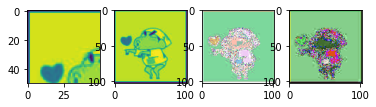

In [71]:
plt.subplot(1, 4, 1)
plt.imshow(Z[0, 0: 50, 0: 50, 1])

plt.subplot(1, 4, 2)
plt.imshow(Z[0, :, :, 1])

plt.subplot(1, 4, 3)
plt.imshow(Z[0, :, :, 1:5].astype('uint8'))

plt.subplot(1, 4, 4)
plt.imshow(Z[0, :, :, 3:6].astype('uint8'))

# 4 - ReLU

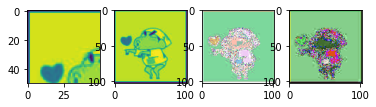

In [72]:
plt.subplot(1, 4, 1)
plt.imshow(A_relu[0, 0: 50, 0: 50, 1])

plt.subplot(1, 4, 2)
plt.imshow(A_relu[0, :, :, 1])

plt.subplot(1, 4, 3)
plt.imshow(A_relu[0, :, :, 1:5].astype('uint8'))

plt.subplot(1, 4, 4)
plt.imshow(A_relu[0, :, :, 3:6].astype('uint8'))

# 5 - MaxPool

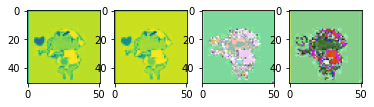

In [75]:
plt.subplot(1, 4, 1)
plt.imshow(A_maxpool[0, :, :, 1])

plt.subplot(1, 4, 2)
plt.imshow(A_maxpool[0, :, :, 2])

plt.subplot(1, 4, 3)
plt.imshow(A_maxpool[0, :, :, 1:5].astype('uint8'))

plt.subplot(1, 4, 4)
plt.imshow(A_maxpool[0, :, :, 3:6].astype('uint8'))